# Customer Retention 
Muhammad Najmi Naufal

"Predict behavior to retain customers. You can analyze all relevant customer data and develop focused customer retention programs." [IBM Sample Data Sets]

About Dataset<br/>
<br/>
Each row represents a customer, each column contains customer’s attributes described on the column Metadata.<br/>
<br/>
The data set includes information about:<br/>

- Customers who left within the last month – the column is called Churn
- Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
- Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
- Demographic info about customers – gender, age range, and if they have partners and dependents

Milestone Objective<br/>
<br/>
The objective is to build an artificial neural network model for Telco customer retention program. The model must predict whether the costumers churned or not.

Dataset Source<br>
<br>
https://www.kaggle.com/datasets/blastchar/telco-customer-churn

## Import Libraries

In [1]:
# general libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import tensorflow as tf
import pickle
import warnings

In [2]:
# sklearn, tensorflow, and other modules
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from tensorflow import keras
from keras.backend import clear_session
from keras.models import Sequential, Model
from keras.layers import Input, Dense
from keras.metrics import Recall
from imblearn.over_sampling import SMOTE

In [3]:
# hide warnings 
warnings.filterwarnings('ignore')

# set random seed
random = 58
np.random.seed(random)
tf.random.set_seed(random)

## Data Loading

In [4]:
# mount google drive to colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# load dataset as pandas DataFrame
df = pd.read_csv('/content/drive/My Drive/hactiv8_ftds/p2_ml1/WA_Fn-UseC_-Telco-Customer-Churn.csv')

# dataset dimensions
df.shape

(7043, 21)

In [6]:
# split test data
data, data_test = train_test_split(df, test_size=0.1, random_state=random, stratify=df['Churn'])

# 5 first entries of data
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
4958,0060-FUALY,Female,0,Yes,No,59,Yes,Yes,Fiber optic,Yes,...,No,No,Yes,No,Month-to-month,Yes,Electronic check,94.75,5597.65,No
983,8603-IJWDN,Male,0,No,No,1,Yes,Yes,Fiber optic,No,...,No,No,No,Yes,Month-to-month,Yes,Electronic check,86.60,86.6,Yes
2023,4795-KTRTH,Female,1,Yes,No,5,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,81.00,371.65,Yes
1632,1899-VXWXM,Male,0,No,No,48,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),106.10,5082.8,Yes
5976,6907-CQGPN,Male,0,No,No,29,No,No phone service,DSL,No,...,No,Yes,No,No,Month-to-month,No,Electronic check,34.30,1004.75,No


In [7]:
# columns name, number of non-nulls, and data type 
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6338 entries, 4958 to 4579
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        6338 non-null   object 
 1   gender            6338 non-null   object 
 2   SeniorCitizen     6338 non-null   int64  
 3   Partner           6338 non-null   object 
 4   Dependents        6338 non-null   object 
 5   tenure            6338 non-null   int64  
 6   PhoneService      6338 non-null   object 
 7   MultipleLines     6338 non-null   object 
 8   InternetService   6338 non-null   object 
 9   OnlineSecurity    6338 non-null   object 
 10  OnlineBackup      6338 non-null   object 
 11  DeviceProtection  6338 non-null   object 
 12  TechSupport       6338 non-null   object 
 13  StreamingTV       6338 non-null   object 
 14  StreamingMovies   6338 non-null   object 
 15  Contract          6338 non-null   object 
 16  PaperlessBilling  6338 non-null   objec

In [8]:
# number of unique values in columns
data.nunique()

customerID          6338
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1540
TotalCharges        5911
Churn                  2
dtype: int64

It's unusual for an object column to have such a number of unique value.

In [9]:
# top repeating values in 'TotalCharges'
print(data.TotalCharges.value_counts().head())

# convert 'TotalCharges' data type to numeric
data.TotalCharges = pd.to_numeric(data['TotalCharges'], errors='coerce')

# replace 'Churn' atributes to numeric
data.Churn = data.Churn.map(dict(No=0, Yes=1))

         11
20.2      9
19.65     8
19.75     8
20.05     8
Name: TotalCharges, dtype: int64


After the columns data type were changed, the empty values in 'TotalCharges' are now NaNs.

In [10]:
# general statistic description
data.describe().T

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,6338.0,0.163616,0.369956,0.00,0.00,0.000,0.000,1.00
tenure,6338.0,32.369202,24.523794,0.00,9.00,29.000,55.000,72.00
MonthlyCharges,6338.0,64.827966,30.060499,18.25,35.75,70.375,89.900,118.75
TotalCharges,6327.0,2289.699044,2266.286741,18.80,399.80,1412.400,3825.025,8672.45
Churn,6338.0,0.265383,0.441572,0.00,0.00,0.000,1.000,1.00


Both 'SeniorCitizen' and 'Churn' contain binary values.

## Exploratory Data Analysis (EDA)

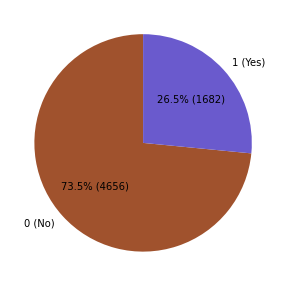

In [11]:
# 'Churn' data distribution chart
target_counts = data.Churn.value_counts().sort_index()

plt.figure(figsize=(5, 5))
labels = ['0 (No)', '1 (Yes)']
colors =  ['Sienna', 'SlateBlue']
plt.pie(target_counts, labels=labels, colors=colors, startangle=90, 
        autopct=lambda p: '{:.1f}% ({:.0f})'.format(p,(p/100)*target_counts.sum()))
plt.show()

Over a quarter of customers left Telco within the last month.

In [12]:
# col_plots function (data distribution, churn rate figures)
def col_plots(df, col, target):
    col_counts = df[col].value_counts().sort_index()
    target_means = pd.DataFrame({'churn rate' : df.groupby(col)[target].mean()}).reset_index()
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    plt.title(col)
    labels = col_counts.index
    colors = sns.color_palette('pastel')
    plt.pie(col_counts, labels=labels, colors=colors, startangle=90, 
            autopct=lambda p: '{:.1f}%'.format(p,(p/100)*col_counts.sum()))
    
    plt.subplot(1, 2, 2)
    col_barplot = sns.barplot(x=col, y='churn rate', data=target_means, palette='pastel')
    col_barplot.set_xticklabels(col_barplot.get_xticklabels(), rotation=15, horizontalalignment='center')
    
    plt.show() 

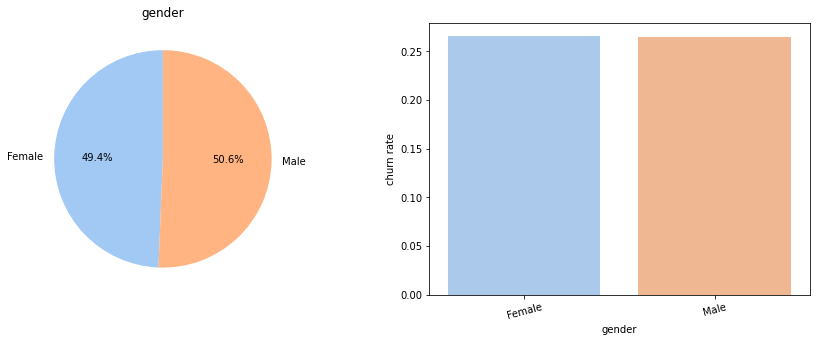

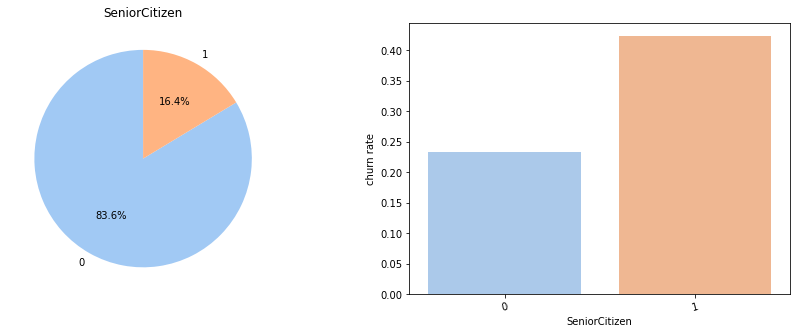

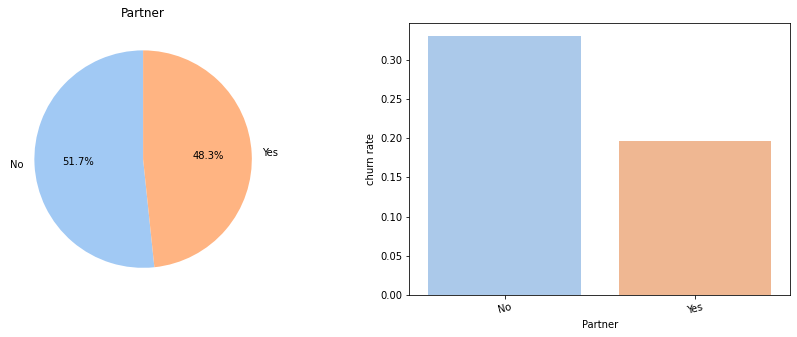

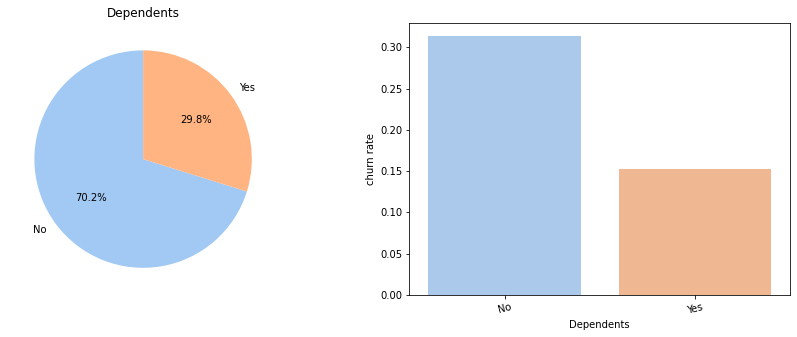

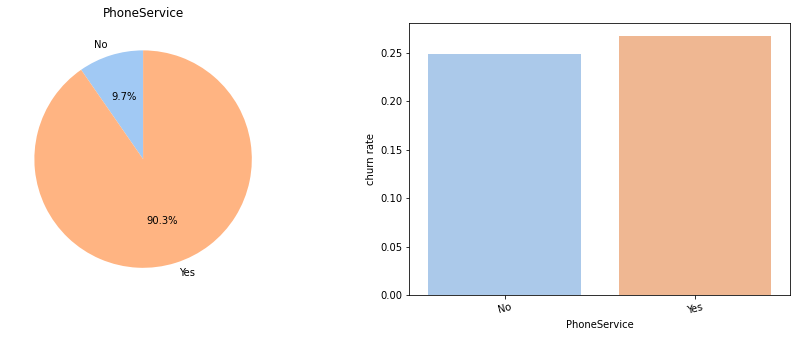

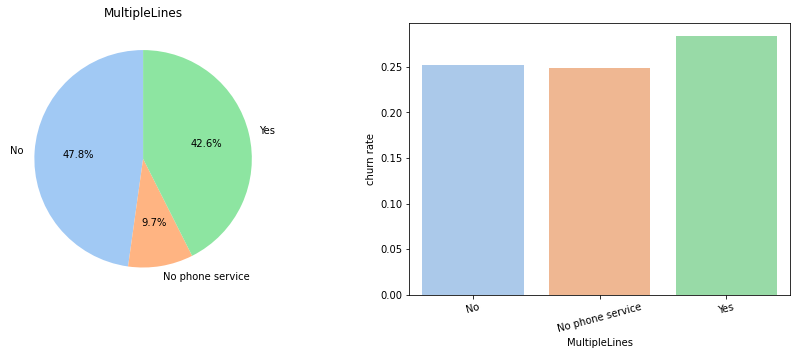

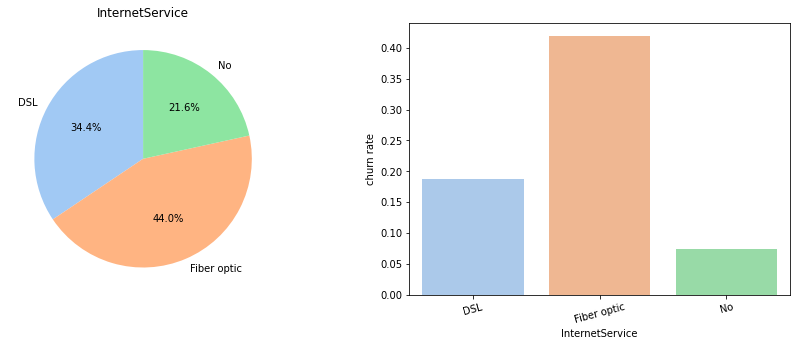

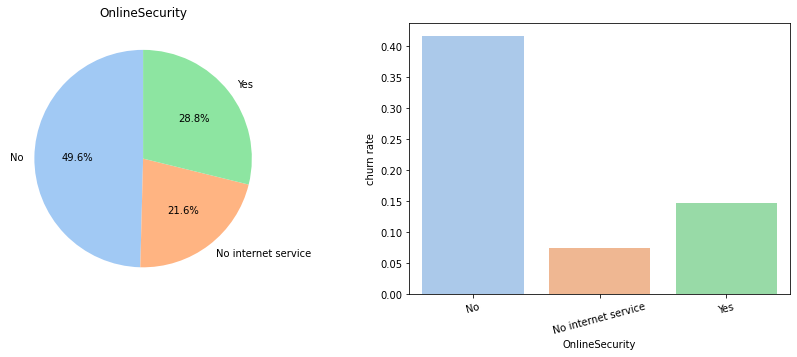

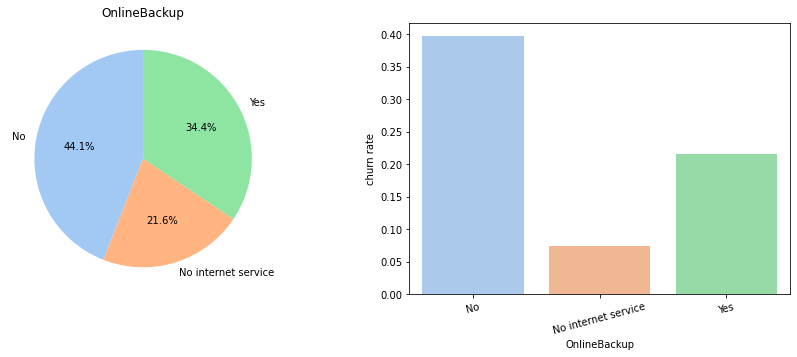

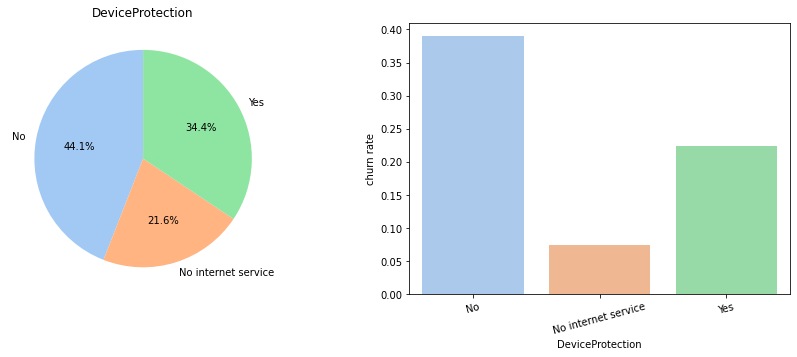

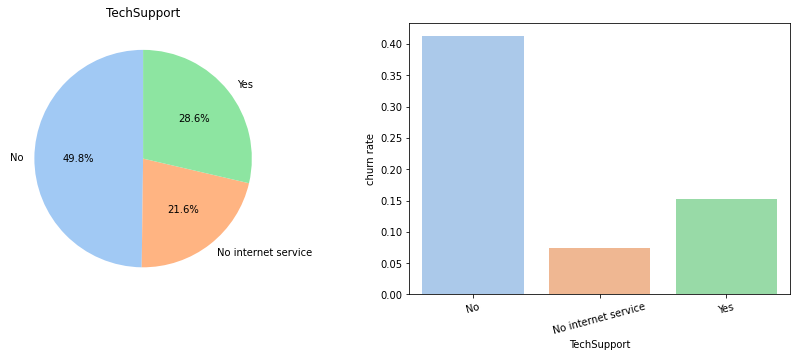

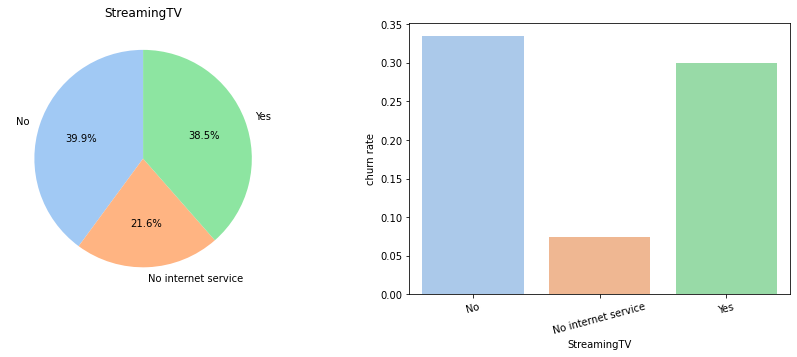

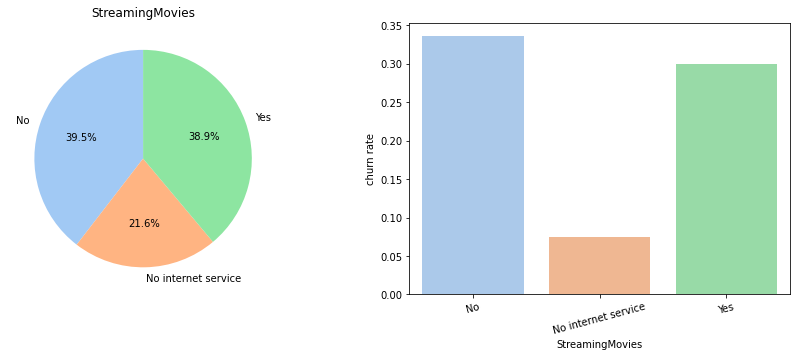

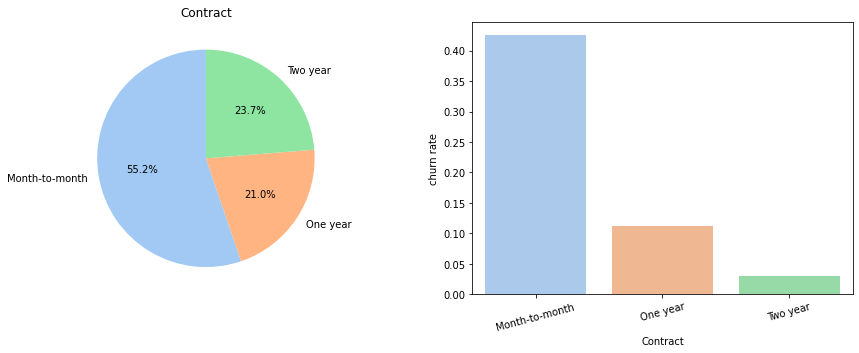

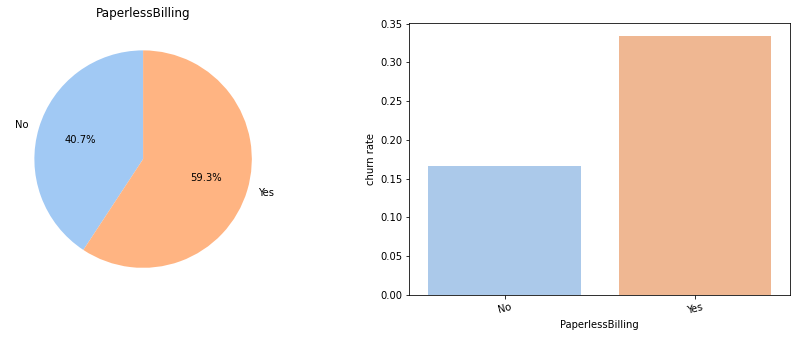

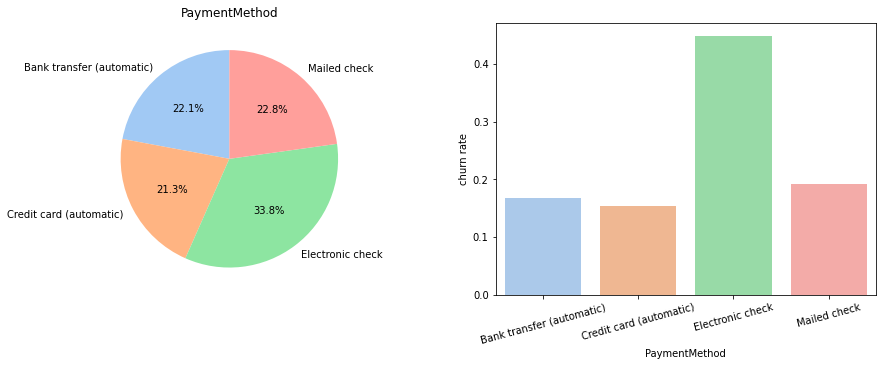

In [13]:
# plot_col list
plot_col = data.loc[:, ~data.columns.isin(['customerID', 'tenure', 'MonthlyCharges', 'TotalCharges', 'Churn'])].columns

# plot_col charts with col_plots
for col in plot_col:
    col_plots(data, col, 'Churn')

Customers who more likely churned: are senior citizen, no partner, no dependents, use fiber optic ISP, don't sign up for services, are on month-to-month contract, use paperless billing, and pay with electronic check. 

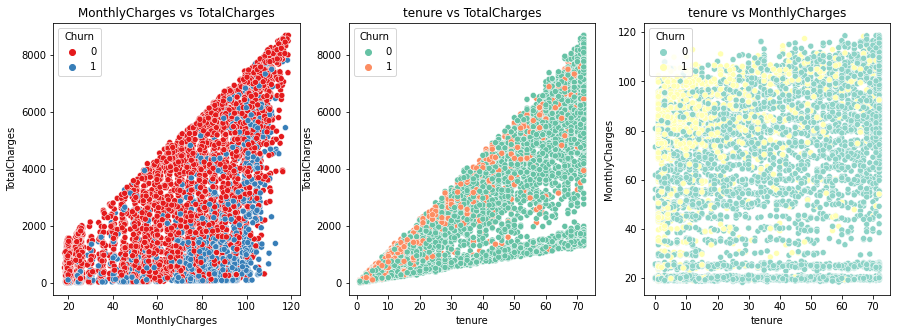

In [14]:
# numeric columns comparison charts
plt.figure(figsize=(15, 5))
    
plt.subplot(1, 3, 1)
plt.title('MonthlyCharges vs TotalCharges')
sns.scatterplot(x='MonthlyCharges', y='TotalCharges', hue='Churn', data=data, palette='Set1')

plt.subplot(1, 3, 2)
plt.title('tenure vs TotalCharges')
sns.scatterplot(x='tenure', y='TotalCharges', hue='Churn', data=data, palette='Set2')

plt.subplot(1, 3, 3)
plt.title('tenure vs MonthlyCharges')
sns.scatterplot(x='tenure', y='MonthlyCharges', hue='Churn', data=data, palette='Set3')

plt.show()

Costumers total charges are related somewhat to their respective monthly charges and tenure.

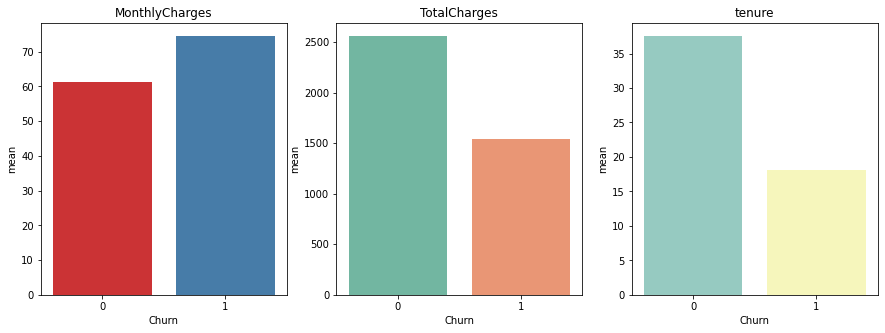

In [15]:
# numeric columns means to 'Churn' charts
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title('MonthlyCharges')
col_means = pd.DataFrame({'mean' : data.groupby('Churn')['MonthlyCharges'].mean()}).reset_index()
sns.barplot(x='Churn', y='mean', data=col_means, palette='Set1')

plt.subplot(1, 3, 2)
plt.title('TotalCharges')
col_means = pd.DataFrame({'mean' : data.groupby('Churn')['TotalCharges'].mean()}).reset_index()
sns.barplot(x='Churn', y='mean', data=col_means, palette='Set2')

plt.subplot(1, 3, 3)
plt.title('tenure')
col_means = pd.DataFrame({'mean' : data.groupby('Churn')['tenure'].mean()}).reset_index()
sns.barplot(x='Churn', y='mean', data=col_means, palette='Set3')

plt.show()

Customers who more likely churned pay more monthly charges and have shorter tenure.

In [16]:
# 'Churn' correlation table
data.corr()['Churn'].sort_values(ascending=False)

Churn             1.000000
MonthlyCharges    0.193403
SeniorCitizen     0.159190
TotalCharges     -0.199023
tenure           -0.351308
Name: Churn, dtype: float64

Costumer churn doesn't correlate strongly with any of these attributes.

## Data Preprocessing

Sequence of data preprocessing:
1. Column Manipulation
2. Dataset Splitting
3. Outlier Detection
4. Missing Value Detection
5. Pipeline (Imputing, Scaling, Encoding)
6. Feature Selection (Correlation, Feature Importance)
7. TensorFlow Pipeline (TF datasets, shuffle, batch)

In [17]:
# binary columns list
binary_col = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']

# replace binary_col atributes to numeric
data.gender = data.gender.map(dict(Female=0, Male=1))

for col in binary_col:
  data[col] = data[col].map(dict(No=0, Yes=1))

In [18]:
# split target column
y = data.pop('Churn')

# split train / validation data
X_train, X_val, y_train, y_val = train_test_split(data, y, test_size=0.2, random_state=random, stratify=y)

# drop unused columns
X_train.drop(['customerID'], axis=1, inplace=True)
X_val.drop(['customerID'], axis=1, inplace=True)

print('X_train shape :', X_train.shape)
print('X_val shape   :', X_val.shape)

X_train shape : (5070, 19)
X_val shape   : (1268, 19)


In [19]:
# numeric columns list
num_col = X_train.select_dtypes(include=np.number).columns.tolist()

# category columns list
cat_col = X_train.loc[:, ~X_train.columns.isin(num_col)].columns.tolist()

print(num_col)
print(cat_col)

['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges']
['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']


In [20]:
# diagnostic_plots function (distplot, boxplot)
def diagnostic_plots(df, var):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    sns.distplot(df[var])
    plt.title('distplot')

    plt.subplot(1, 2, 2)
    sns.boxplot(y=df[var])
    plt.title('boxplot')

    plt.show()

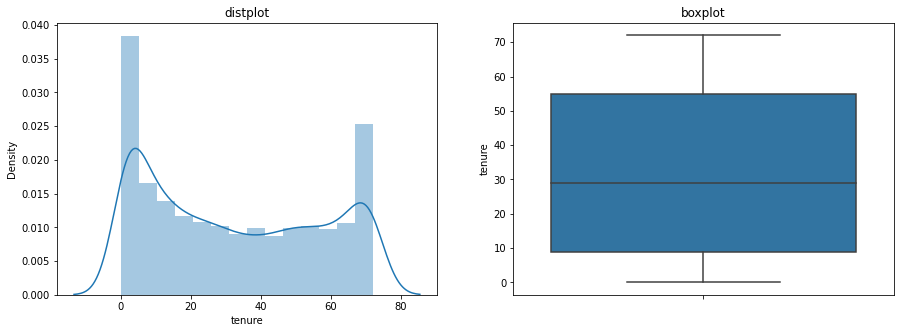

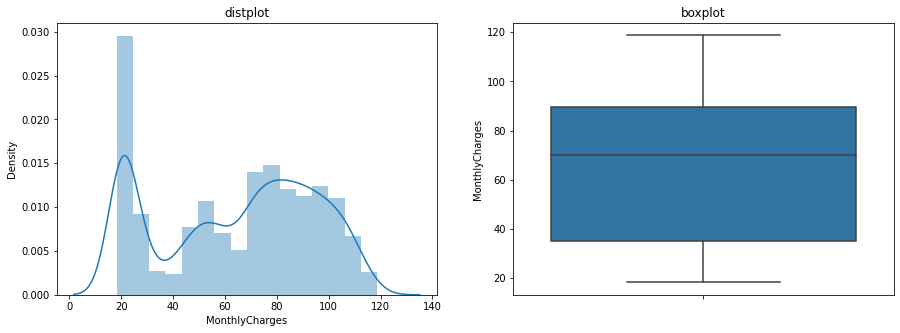

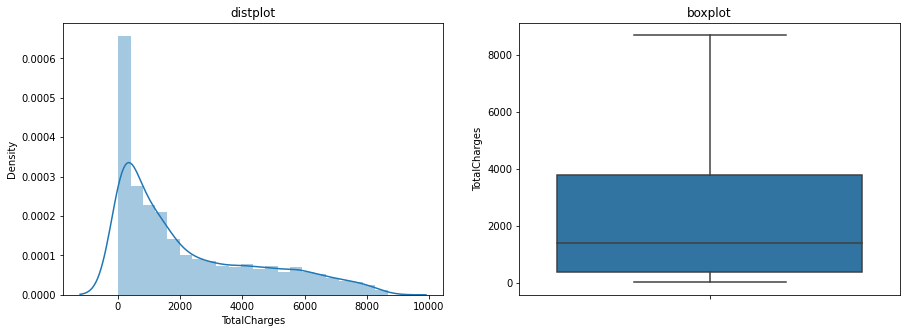

In [21]:
# check columns list
check_col = ['tenure', 'MonthlyCharges', 'TotalCharges']

# diagnostic_plots of check_col (data distribution, outlier detection)
for col in check_col:
    diagnostic_plots(X_train, col)

In [22]:
# null values detection
print('null in X_train : ', X_train.isna().sum().sum())
print('null in y_train : ', y_train.isna().sum())
print('null in X_val   : ', X_val.isna().sum().sum())
print('null in y_val   : ', y_val.isna().sum())

null in X_train :  9
null in y_train :  0
null in X_val   :  2
null in y_val   :  0


In [23]:
# pipelines
num_pipe = make_pipeline(SimpleImputer(strategy='median'),
                             MinMaxScaler())

cat_pipe = make_pipeline(OneHotEncoder())

col_trans = ColumnTransformer([
    ('num_pipe', num_pipe, num_col),
    ('cat_pipe', cat_pipe, cat_col)])

prep_pipe = Pipeline(steps=[
    ['prep', col_trans]], 
    memory='cache_folder')

In [24]:
# fit pipeline
prep_pipe.fit(X_train)

Pipeline(memory='cache_folder',
         steps=[['prep',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'tenure', 'PhoneService',
                                                   'PaperlessBilling',
                                                   'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('cat_pipe',
                        

In [25]:
# transform pipeline
X_train_pipe = prep_pipe.transform(X_train)
X_val_pipe = prep_pipe.transform(X_val)

print('X_train_pipe shape :', X_train_pipe.shape)
print('X_val_pipe shape   :', X_val_pipe.shape)

X_train_pipe shape : (5070, 40)
X_val_pipe shape   : (1268, 40)


In [26]:
# features correlation
col_corr = pd.DataFrame(X_train_pipe).corr().abs().unstack().sort_values().to_frame().reset_index()

# above threshold features correlation
col_corr_hi = col_corr[col_corr[0] > 0.9]['level_0'].value_counts()

# features that correlate above threshold with multiple features
col_corr_hi.head(9)

22    7
28    7
16    7
14    7
25    7
19    7
31    7
5     2
10    2
Name: level_0, dtype: int64

In [27]:
# random forest
rf = RandomForestClassifier(random_state=random, n_jobs=-1)
rf.fit(X_train_pipe, y_train)

RandomForestClassifier(n_jobs=-1, random_state=58)

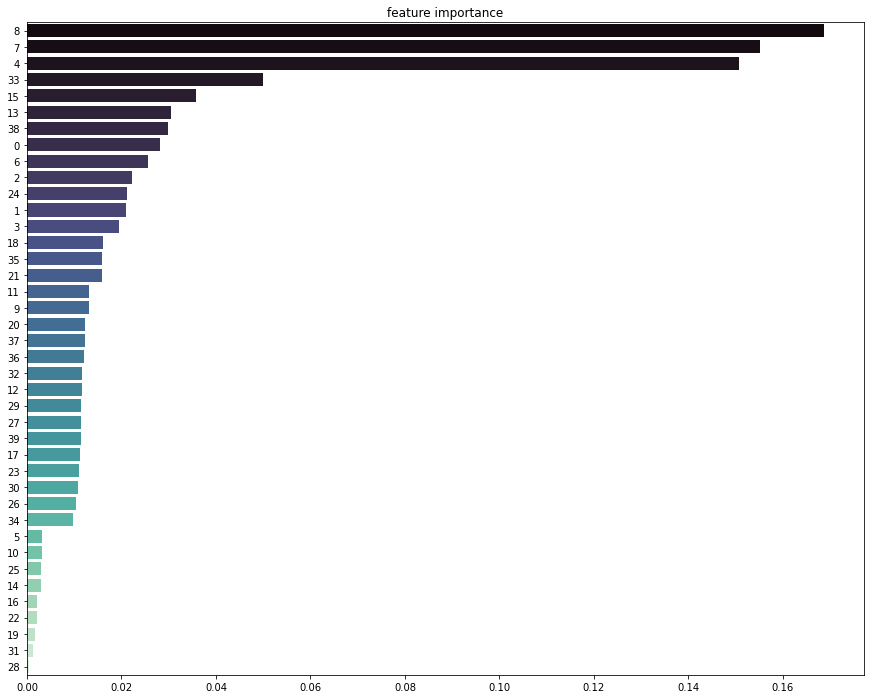

In [28]:
# rf feature importance
imp = pd.Series(data=rf.feature_importances_).sort_values(ascending=False)

plt.figure(figsize=(15,12))
y = imp.index
x = imp.values
plt.title('feature importance')
sns.barplot(x, y, palette='mako', orient='h', order=y)
plt.show()

In [29]:
# correlation vs rf comparison
corr_list = col_corr_hi.head(9).index.tolist()
rf_list = imp.tail(9).index.tolist()

corr_list.sort()
rf_list.sort()

if corr_list == rf_list:
  print ('same')
else :
  print ('different')

same


In [30]:
# unimportant features list
del_col = [5, 10, 14, 16, 19, 22, 25, 28, 31]

# remove unimportant features
X_train_select = np.delete(X_train_pipe, del_col, 1)
X_val_select = np.delete(X_val_pipe, del_col, 1)

print('X_train_select shape :', X_train_select.shape)
print('X_val_select shape   :', X_val_select.shape)

X_train_select shape : (5070, 31)
X_val_select shape   : (1268, 31)


In [31]:
# buffer size as ratio of data length
buffer_train = int(1 * len(X_train_select))
buffer_val = int(1 * len(X_val_select))

print('buffer size (train) :', buffer_train)
print('buffer size (val)   :', buffer_val)

buffer size (train) : 5070
buffer size (val)   : 1268


In [32]:
# tf pipelines
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_select, y_train)).shuffle(buffer_size=buffer_train, seed=random).batch(64)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val_select, y_val)).shuffle(buffer_size=buffer_val, seed=random).batch(64)

## Base Model Definition and Training

In [33]:
# SEQUENTIAL API

# resets all state generated by keras
clear_session()

# build architecture
model = Sequential()
model.add(Dense(16, activation='sigmoid', kernel_initializer=keras.initializers.glorot_uniform(seed=random), input_shape=(31,)))
model.add(Dense(8, activation='sigmoid', kernel_initializer=keras.initializers.glorot_uniform(seed=random)))
model.add(Dense(4, activation='sigmoid', kernel_initializer=keras.initializers.glorot_uniform(seed=random)))
model.add(Dense(1, activation='sigmoid', kernel_initializer=keras.initializers.glorot_uniform(seed=random)))

# compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', Recall(name='recall')])

# train model
history = model.fit(train_dataset, epochs=20, validation_data=val_dataset)

Epoch 1/20
80/80 [==============================] - 3s 17ms/step - loss: 0.7607 - accuracy: 0.2694 - recall: 0.9948 - val_loss: 0.6930 - val_accuracy: 0.5331 - val_recall: 0.5312
Epoch 2/20
80/80 [==============================] - 1s 8ms/step - loss: 0.6578 - accuracy: 0.7229 - recall: 0.0112 - val_loss: 0.6299 - val_accuracy: 0.7342 - val_recall: 0.0000e+00
Epoch 3/20
80/80 [==============================] - 1s 8ms/step - loss: 0.6122 - accuracy: 0.7347 - recall: 0.0000e+00 - val_loss: 0.5981 - val_accuracy: 0.7342 - val_recall: 0.0000e+00
Epoch 4/20
80/80 [==============================] - 0s 6ms/step - loss: 0.5897 - accuracy: 0.7347 - recall: 0.0000e+00 - val_loss: 0.5833 - val_accuracy: 0.7342 - val_recall: 0.0000e+00
Epoch 5/20
80/80 [==============================] - 0s 6ms/step - loss: 0.5786 - accuracy: 0.7347 - recall: 0.0000e+00 - val_loss: 0.5749 - val_accuracy: 0.7342 - val_recall: 0.0000e+00
Epoch 6/20
80/80 [==============================] - 0s 6ms/step - loss: 0.5690 - 

In [34]:
# FUNCTIONAL API

# resets all state generated by keras
clear_session()

# build architecture
data_in = Input(shape=(31,))
hidden_1 = Dense(16, activation='sigmoid', kernel_initializer=keras.initializers.glorot_uniform(seed=random))(data_in)
hidden_2 = Dense(8, activation='sigmoid', kernel_initializer=keras.initializers.glorot_uniform(seed=random))(hidden_1)
hidden_3 = Dense(4, activation='sigmoid', kernel_initializer=keras.initializers.glorot_uniform(seed=random))(hidden_2)
data_out = Dense(1, activation='sigmoid', kernel_initializer=keras.initializers.glorot_uniform(seed=random))(hidden_3)
model2 = Model(inputs=data_in, outputs=data_out)

# compile model
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', Recall(name='recall')])

# train model
history2 = model2.fit(train_dataset, epochs=20, validation_data=val_dataset)

Epoch 1/20
80/80 [==============================] - 3s 13ms/step - loss: 0.7639 - accuracy: 0.2661 - recall: 1.0000 - val_loss: 0.6963 - val_accuracy: 0.3462 - val_recall: 0.9377
Epoch 2/20
80/80 [==============================] - 0s 3ms/step - loss: 0.6606 - accuracy: 0.7211 - recall: 0.0647 - val_loss: 0.6320 - val_accuracy: 0.7342 - val_recall: 0.0000e+00
Epoch 3/20
80/80 [==============================] - 0s 3ms/step - loss: 0.6142 - accuracy: 0.7347 - recall: 0.0000e+00 - val_loss: 0.5994 - val_accuracy: 0.7342 - val_recall: 0.0000e+00
Epoch 4/20
80/80 [==============================] - 0s 4ms/step - loss: 0.5903 - accuracy: 0.7347 - recall: 0.0000e+00 - val_loss: 0.5836 - val_accuracy: 0.7342 - val_recall: 0.0000e+00
Epoch 5/20
80/80 [==============================] - 0s 4ms/step - loss: 0.5784 - accuracy: 0.7347 - recall: 0.0000e+00 - val_loss: 0.5745 - val_accuracy: 0.7342 - val_recall: 0.0000e+00
Epoch 6/20
80/80 [==============================] - 0s 4ms/step - loss: 0.5683 - 

## Base Model Evaluation

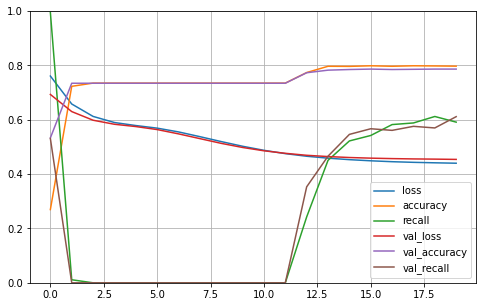

In [35]:
# SEQUENTIAL API model metrics 
metrics = pd.DataFrame(history.history)
metrics.plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

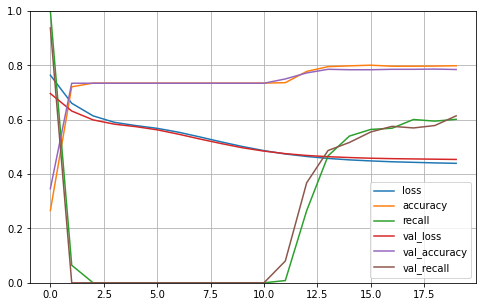

In [36]:
# FUNCTIONAL API model metrics 
metrics2 = pd.DataFrame(history2.history)
metrics2.plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

Both API show similar result. The gap between train and val lines are not clearly visible, indicating good fit.

In [37]:
# predict the train data (SEQUENTIAL API)
y_pred_train = model.predict(X_train_select)
y_pred_train = np.where(y_pred_train >= 0.5, 1, 0).squeeze()

# classification report
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86      3725
           1       0.61      0.63      0.62      1345

    accuracy                           0.80      5070
   macro avg       0.74      0.74      0.74      5070
weighted avg       0.80      0.80      0.80      5070



In [38]:
# predict the train data (FUNCTIONAL API)
y_pred_train2 = model2.predict(X_train_select)
y_pred_train2 = np.where(y_pred_train2 >= 0.5, 1, 0).squeeze()

# classification report
print(classification_report(y_train, y_pred_train2))

              precision    recall  f1-score   support

           0       0.87      0.86      0.86      3725
           1       0.61      0.63      0.62      1345

    accuracy                           0.80      5070
   macro avg       0.74      0.74      0.74      5070
weighted avg       0.80      0.80      0.80      5070



In [39]:
# predict the validation data (SEQUENTIAL API)
y_pred = model.predict(X_val_select)
y_pred = np.where(y_pred >= 0.5, 1, 0).squeeze()

# classification report
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.85      0.85       931
           1       0.60      0.61      0.60       337

    accuracy                           0.79      1268
   macro avg       0.73      0.73      0.73      1268
weighted avg       0.79      0.79      0.79      1268



In [40]:
# predict the validation data (FUNCTIONAL API)
y_pred2 = model2.predict(X_val_select)
y_pred2 = np.where(y_pred2 >= 0.5, 1, 0).squeeze()

# classification report
print(classification_report(y_val, y_pred2))

              precision    recall  f1-score   support

           0       0.86      0.85      0.85       931
           1       0.59      0.61      0.60       337

    accuracy                           0.78      1268
   macro avg       0.72      0.73      0.73      1268
weighted avg       0.79      0.78      0.79      1268



The difference between train dan val accuracy is around 1-2%, while the difference between class 0 and 1 metrics are quite significant. The focus of model improvement is to increase class 1 recall, thus minimizing class 1 false negatives (true churn, predicted not churn).

## Model Improvement

Changes made to the dense layer args (except final layer):
- activation : sigmoid > softmax
- kernel_initializer : glorot_uniform > GlorotNormal.

Explanation :
- activation : Activation function to use
- kernel_initializer : Initializer for the kernel weights matrix.

In [41]:
# resets all state generated by keras
clear_session()

# build architecture
model3 = Sequential()
model3.add(Dense(16, activation='softmax', kernel_initializer=keras.initializers.GlorotNormal(seed=random), input_shape=(31,)))
model3.add(Dense(8, activation='softmax', kernel_initializer=keras.initializers.GlorotNormal(seed=random)))
model3.add(Dense(4, activation='softmax', kernel_initializer=keras.initializers.GlorotNormal(seed=random)))
model3.add(Dense(1, activation='sigmoid', kernel_initializer=keras.initializers.glorot_uniform(seed=random)))

# compile model
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', Recall(name='recall')])

# train model
history3 = model3.fit(train_dataset, epochs=20, validation_data=val_dataset)

Epoch 1/20
80/80 [==============================] - 1s 8ms/step - loss: 0.6184 - accuracy: 0.7347 - recall: 0.0000e+00 - val_loss: 0.6076 - val_accuracy: 0.7342 - val_recall: 0.0000e+00
Epoch 2/20
80/80 [==============================] - 0s 4ms/step - loss: 0.5999 - accuracy: 0.7347 - recall: 0.0000e+00 - val_loss: 0.5938 - val_accuracy: 0.7342 - val_recall: 0.0000e+00
Epoch 3/20
80/80 [==============================] - 0s 4ms/step - loss: 0.5894 - accuracy: 0.7347 - recall: 0.0000e+00 - val_loss: 0.5861 - val_accuracy: 0.7342 - val_recall: 0.0000e+00
Epoch 4/20
80/80 [==============================] - 0s 4ms/step - loss: 0.5830 - accuracy: 0.7347 - recall: 0.0000e+00 - val_loss: 0.5809 - val_accuracy: 0.7342 - val_recall: 0.0000e+00
Epoch 5/20
80/80 [==============================] - 0s 4ms/step - loss: 0.5784 - accuracy: 0.7347 - recall: 0.0000e+00 - val_loss: 0.5768 - val_accuracy: 0.7342 - val_recall: 0.0000e+00
Epoch 6/20
80/80 [==============================] - 0s 3ms/step - loss

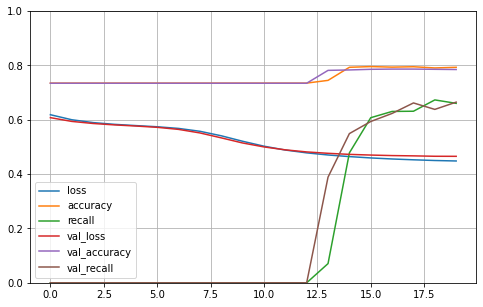

In [42]:
# improved model metrics 
metrics3 = pd.DataFrame(history3.history)
metrics3.plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [43]:
# predict the train data (improved)
y_pred_train3 = model3.predict(X_train_select)
y_pred_train3 = np.where(y_pred_train3 >= 0.5, 1, 0).squeeze()

# classification report
print(classification_report(y_train, y_pred_train3))

              precision    recall  f1-score   support

           0       0.88      0.83      0.85      3725
           1       0.59      0.67      0.63      1345

    accuracy                           0.79      5070
   macro avg       0.73      0.75      0.74      5070
weighted avg       0.80      0.79      0.79      5070



In [44]:
# predict the validation data (improved)
y_pred3 = model3.predict(X_val_select)
y_pred3 = np.where(y_pred3 >= 0.5, 1, 0).squeeze()

# classification report
print(classification_report(y_val, y_pred3))

              precision    recall  f1-score   support

           0       0.87      0.83      0.85       931
           1       0.58      0.66      0.62       337

    accuracy                           0.78      1268
   macro avg       0.73      0.75      0.74      1268
weighted avg       0.80      0.78      0.79      1268



The model class 1 recall has noticeably improved by the changes made.

## Model Improvement (SMOTE)

Due to class imbalance, the model tends to predict the majority class more often than not. Synthetic minority oversampling technique (SMOTE) can be utilized to match the number of minority with the majority. 

In [45]:
# oversampling using SMOTE
smote = SMOTE(random_state=random, sampling_strategy = 'minority')
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_select, y_train)

# oversampled target distribution
y_train_balanced.value_counts()

1    3725
0    3725
Name: Churn, dtype: int64

In [46]:
# tf pipeline 
buffer_smote = int(1 * len(X_train_balanced))
smote_dataset = tf.data.Dataset.from_tensor_slices((X_train_balanced, y_train_balanced)).shuffle(buffer_size=buffer_smote, seed=random).batch(64)

In [47]:
# resets all state generated by keras
clear_session()

# build architecture
data_in = Input(shape=(31,))
hidden_1 = Dense(16, activation='softmax', kernel_initializer=keras.initializers.GlorotNormal(seed=random))(data_in)
hidden_2 = Dense(8, activation='softmax', kernel_initializer=keras.initializers.GlorotNormal(seed=random))(hidden_1)
hidden_3 = Dense(4, activation='softmax', kernel_initializer=keras.initializers.GlorotNormal(seed=random))(hidden_2)
data_out = Dense(1, activation='sigmoid', kernel_initializer=keras.initializers.glorot_uniform(seed=random))(hidden_3)
model4 = Model(inputs=data_in, outputs=data_out)

# compile model
model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', Recall(name='recall')])

# train model
history4 = model4.fit(smote_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10
117/117 [==============================] - 2s 6ms/step - loss: 0.6990 - accuracy: 0.5000 - recall: 0.0000e+00 - val_loss: 0.6649 - val_accuracy: 0.7342 - val_recall: 0.0000e+00
Epoch 2/10
117/117 [==============================] - 1s 4ms/step - loss: 0.6911 - accuracy: 0.5000 - recall: 0.0000e+00 - val_loss: 0.6791 - val_accuracy: 0.7342 - val_recall: 0.0000e+00
Epoch 3/10
117/117 [==============================] - 1s 5ms/step - loss: 0.6820 - accuracy: 0.6689 - recall: 0.5017 - val_loss: 0.6768 - val_accuracy: 0.7311 - val_recall: 0.7745
Epoch 4/10
117/117 [==============================] - 1s 6ms/step - loss: 0.6620 - accuracy: 0.7608 - recall: 0.8040 - val_loss: 0.6568 - val_accuracy: 0.7382 - val_recall: 0.7656
Epoch 5/10
117/117 [==============================] - 0s 4ms/step - loss: 0.6312 - accuracy: 0.7679 - recall: 0.7968 - val_loss: 0.6287 - val_accuracy: 0.7461 - val_recall: 0.7507
Epoch 6/10
117/117 [==============================] - 1s 4ms/step - loss: 0.5991 - a

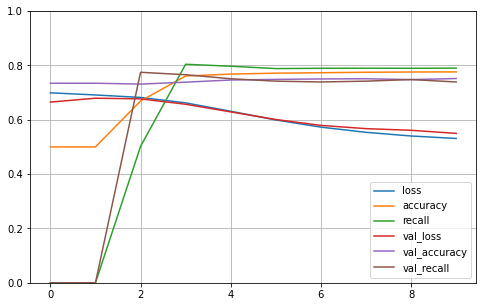

In [48]:
# oversampled model metrics 
metrics4 = pd.DataFrame(history4.history)
metrics4.plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

This model overfit quicker than the base model, so the number of epochs have been halved.

In [49]:
# predict the oversampled train data (SMOTE)
y_pred_train4 = model4.predict(X_train_balanced)
y_pred_train4 = np.where(y_pred_train4 >= 0.5, 1, 0).squeeze()

# classification report
print(classification_report(y_train_balanced, y_pred_train4))

              precision    recall  f1-score   support

           0       0.79      0.76      0.77      3725
           1       0.77      0.79      0.78      3725

    accuracy                           0.78      7450
   macro avg       0.78      0.78      0.78      7450
weighted avg       0.78      0.78      0.78      7450



The metrics are all almost identical. This is expected when predicting oversampled data.

In [50]:
# predict the original train data (SMOTE)
y_pred_train4_ori = model4.predict(X_train_select)
y_pred_train4_ori = np.where(y_pred_train4_ori >= 0.5, 1, 0).squeeze()

# classification report
print(classification_report(y_train, y_pred_train4_ori))

              precision    recall  f1-score   support

           0       0.90      0.76      0.82      3725
           1       0.54      0.77      0.63      1345

    accuracy                           0.76      5070
   macro avg       0.72      0.77      0.73      5070
weighted avg       0.81      0.76      0.77      5070



In [51]:
# predict the validation data (SMOTE)
y_pred4 = model4.predict(X_val_select)
y_pred4 = np.where(y_pred4 >= 0.5, 1, 0).squeeze()

# classification report
print(classification_report(y_val, y_pred4))

              precision    recall  f1-score   support

           0       0.89      0.76      0.82       931
           1       0.52      0.74      0.61       337

    accuracy                           0.75      1268
   macro avg       0.71      0.75      0.71      1268
weighted avg       0.79      0.75      0.76      1268



The class 0 precision and class 1 recall increase. This model predicted more costumers had churned.

## Model Saving

In [52]:
# save model and pipeline for deployment
model4.save('p2ml1_model.h5')

with open('p2ml1_prep_pipe.pkl', 'wb') as f:
  pickle.dump(prep_pipe, f)

## Model Inference

In [53]:
# convert 'TotalCharges' data type to numeric
data_test.TotalCharges = pd.to_numeric(data_test['TotalCharges'], errors='coerce')

# replace 'Churn' atributes to numeric
data_test.Churn = data_test.Churn.map(dict(No=0, Yes=1))

# replace binary_col atributes to numeric
data_test.gender = data_test.gender.map(dict(Female=0, Male=1))

# replace binary_col atributes to numeric
for col in binary_col:
  data_test[col] = data_test[col].map(dict(No=0, Yes=1))

# split target column
y_test = data_test.pop('Churn')

# drop unused columns
data_test.drop(['customerID'], axis=1, inplace=True)

# load pipeline
with open('p2ml1_prep_pipe.pkl', 'rb') as f:
  pipe = pickle.load(f)

# transform pipeline
X_test_pipe = pipe.transform(data_test)

# feature selection
X_test_select = np.delete(X_test_pipe, del_col, 1)

# load model
model_fix = keras.models.load_model('p2ml1_model.h5')

# predict the test data
y_pred_test = model_fix.predict(X_test_select)
y_pred_test = np.where(y_pred_test >= 0.5, 1, 0).squeeze()

Retracing the steps...

In [54]:
# classification report
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.91      0.75      0.82       518
           1       0.53      0.79      0.64       187

    accuracy                           0.76       705
   macro avg       0.72      0.77      0.73       705
weighted avg       0.81      0.76      0.77       705



There difference between test, train, and val metrics are insignifcant. This prove the model does not overfit. 

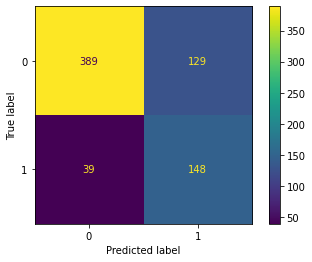

In [55]:
# confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)

From 705 costumers, there are only 39 churning customer who are predicted to stay.

In [56]:
# test vs predict comparison
churn_df = pd.DataFrame({'test': y_test, 'pred': y_pred_test})
churn_df.replace({0: 'No', 1: 'Yes'}, inplace=True)
churn_df.sample(10, random_state=random)

,test,pred
2750,No,No
1643,No,Yes
6512,No,Yes
5347,No,No
6591,Yes,Yes
2940,Yes,Yes
4816,No,No
2215,No,No
6746,Yes,No
5188,No,Yes


From 10 samples, there ratio between true yes:no is 7:3. The model splits the predictition evenly, thus 2 wrong prediction.

## Conclusion

The ANN model built for Telco custumer retention program can predict over 70% of positive churn.